<h1><center> Training of a closure designed with `TrainableScalar` for the PKF applied to the Burgers dynamics </center></h1>
<center>
    Olivier Pannekoucke <br> 2020
</center>

The aim is to train a closure to predict the uncertainty dynamics for the Burgers dynamics.

The notebook present the situation where uknown physical processes are represented by a symbolic expression where `TrainableScalar` are used.

---
<center> <b>Table of contents</b> </center>

 1. [Introduction](#introduction)
 1. [The Burgers dynamics](#the-burgers-dynamics)
 1. [PKF for the Burgers dynamics](#pkf-forthe-burgers-dynamics)
 1. [Numerical application](#numerical-application)
   - [Generation of a database](#generation-of-a-database)
   - [Training of the closure](#training-of-the-closure)
   - [Comparison with the theoretically designed closure](#comparison-with-the-theoretically-designed-closure)
 1. [Conclusion](#conclusion)
 ---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Introduction <a id='introduction'>

The aim is to design a NN which merges known and unknown physics.

In [2]:
import sympy
from sympy import (Function, symbols, init_printing, Derivative, 
                   latex, Add, Mul, Pow, 
                   Integer, Rational, Float, Symbol,
                   srepr, Tuple
                  )
init_printing() 

## The Burgers dynamics

In [3]:
from pdenetgen import NNModelBuilder, Eq
import tensorflow.keras as keras

In [4]:
def display_system(system):
    print(50*'*')
    for equation in system:
        display(equation)
        print(50*'*')

#### Set of the function and symbols <a id='burgers-pkf-sympy-definition'>

In [5]:
from pdenetgen import t
x = symbols('x')

u = Function('u')(t,x)
closure = sympy.Function('closure')(t,x)
V = Function('{V_{u}}')(t,x)
nu = Function('{\\nu_{u,xx}}')(t,x)
Kappa = symbols('\\kappa')

#### Set constants for numerical experiments <a id='burgers-pkf-num-definition'>

In [6]:
# Constant setting following Pannekoucke et al. (2018)
n = 241
kappa = 0.0025
dt = 0.002

#### Set of the Burgers equation <a id='burgers-pkf-dyn-burgers'>

**************************************************


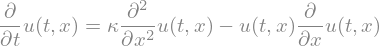

**************************************************


In [7]:
burgers_dynamics = [
        Eq(
        Derivative(u,t),
        Kappa*Derivative(u,x,2)-u*Derivative(u,x)
      ),
]
display_system(burgers_dynamics)

In [8]:
burgers_NN_builder = NNModelBuilder(burgers_dynamics, "Burgers")

In [9]:
burgers_NN_builder.prognostic_functions[0].input_shape

('input_shape_x', 1)

In [10]:
burgers_NN_builder.write_module()

class Burgers has been written in module burgers in file burgers.py


In [11]:
print(burgers_NN_builder.code)
exec(burgers_NN_builder.code)
burgers = Burgers(shape=(n,), kappa=kappa)

from pdenetgen.model import Model
import numpy as np
import tensorflow.keras as keras
from pdenetgen.symbolic.nn_builder import DerivativeFactory, TrainableScalarLayerFactory

class Burgers(Model):

    # Prognostic functions (sympy functions):
    prognostic_functions = (
            'u',    # Write comments on the function here
        )

    
    
    # Spatial coordinates
    coordinates = (
            'x',    # Write comments on the coordinate here
        )

    

    
    # Set constants
    constants = (
            'kappa',    # Writes comment on the constant here
        )
    

    def __init__(self, shape=None, lengths=None, **kwargs):

        super().__init__() # Time scheme is set from Model.__init__()
                
        #---------------------------------
        # Set index array from coordinates
        #---------------------------------
        
        # a) Set shape
        shape = len(self.coordinates)*(100,) if shape is None else shape 
        if len(shape

##### Example of forecast from a given initial condition

In [12]:
import matplotlib.pyplot as plt

def plot_results(data, label=None, labelx=True, title=None, save_file=None, normalisation=None, 
                 selected_times=None,style=None, name=None, alpha=1., bolds=[0., 1.]):
    
    normalisation = 1. if normalisation is None else normalisation
                 
    selected_times = [time for time in data] if selected_times is None else selected_times
                 
    style = 'k' if style is None else style
                 
    for time in selected_times:
        lalpha = alpha if time in bolds else 0.2
        lname = name if time==selected_times[-1] else None
        plt.plot(domain.x[0],data[time]/normalisation, style, alpha = lalpha, label=lname)
                 
    if labelx:
        plt.xlabel('$x/D$', fontsize=15)
    if label:
        plt.ylabel(label, fontsize=15)
    if title:
        plt.title(title)
    if save_file:
        plt.savefig(save_file)

In [13]:
domain = burgers
# Set initial condition for 'u'
U0=0.25*( 1+np.cos(2*np.pi/ domain.lengths[0]  *(domain.x[0]-0.25)) )
Umax = U0.max()

In [14]:
burgers.set_dt(dt)
end_time_forecast = 1.
times = burgers.window(end_time_forecast)
saved_times = times[::50]
print('saved_times :' ,saved_times)

saved_times : [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [15]:
burgers._make_trend_model()

In [16]:
forecast = burgers.forecast(times, np.array([U0.reshape((1,)+U0.shape+(1,)) ]))

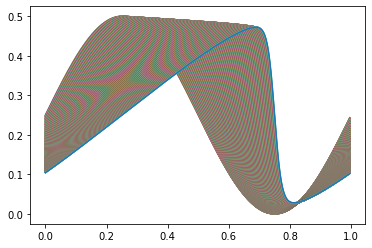

In [17]:
for time in times:
    plt.plot(domain.x[0], forecast[time][0,0,:,0])

## PKF for the Burgers dynamics 

#### Set of the PKF equations for the Burgers equation <a id='burgers-pkf-dyn-pkf'>

**************************************************


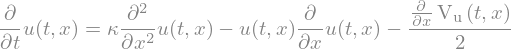

**************************************************


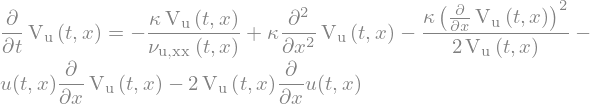

**************************************************


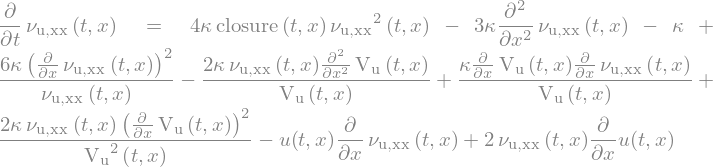

**************************************************


In [18]:
# From Pannekoucke et al. (2018)

pkf_dynamics = [
    # Trend of the expectation of 'u'
    Eq(
        Derivative(u,t),
        Kappa*Derivative(u,x,2)-u*Derivative(u,x)-Derivative(V,x)/Integer(2)
      ),
    # Trend of the variance
    Eq(
        Derivative(V,t),
        -Kappa*V/nu + Kappa*Derivative(V,x,2)-Kappa*Derivative(V,x)**Integer(2)/(Integer(2)*V)
        -u*Derivative(V,x)-Integer(2)*V*Derivative(u,x)
      ),
    # Trend of the diffusion
    Eq(
        Derivative(nu,t),
        Integer(4)*Kappa*nu**Integer(2)*closure
        -Integer(3)*Kappa*Derivative(nu,x,2)
        -Kappa
        +Integer(6)*Kappa*Derivative(nu,x)**Integer(2)/nu
        -Integer(2)*Kappa*nu*Derivative(V,x,2)/V
        +Kappa*Derivative(V,x)*Derivative(nu,x)/V
        +Integer(2)*Kappa*nu*Derivative(V,x)**Integer(2)/V**Integer(2)
        -u*Derivative(nu,x)
        +Integer(2)*nu*Derivative(u,x)
    )
]

display_system(pkf_dynamics)

**Introduction of the closure ine the PKF dynamics**

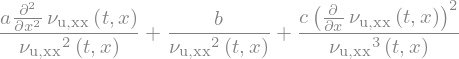

In [19]:
from pdenetgen import TrainableScalar

# Set the closure by using TrainableScalar
a, b, c = [TrainableScalar(l) for l in 'abc']
closure_proposal = a*Derivative(nu,x,2)/nu**Integer(2)+b*1/nu**Integer(2)+\
                c*Derivative(nu,x)**2/nu**Integer(3)
display(closure_proposal)

In [20]:
# Replace the closure(t,x) by the proposed closure
pkf_dynamics[2] = pkf_dynamics[2].subs(Function('closure')(t,x), closure_proposal)

# Generate the NN code leading to the ClosedPKFBurgers class.
exec(NNModelBuilder(pkf_dynamics,'ClosedPKFBurgers').code)

**Sample of code generated to define the ClosedPKFBurgers class**
```python
[..]
pow_21 = keras.layers.multiply([div_17,div_17,] ,name='PowLayer_21')
mul_28 = keras.layers.multiply([pow_21,Dnu_u_xx_x_o2],name='MulLayer_28')
train_scalar_9 = TrainableScalarLayerFactory(input_shape=mul_28.shape, name='TrainableScalar_a', 
                init_value=0,use_bias=False,mean=0.0,stddev=1.0,seed=None,wl2=None)(mul_28)                
                #TrainableScalar name: 'a' 
add_8 = keras.layers.add([train_scalar_7,train_scalar_8,train_scalar_9],name='AddLayer_8')
mul_26 = keras.layers.multiply([pow_17,add_8],name='MulLayer_26')
[..]
```

In [21]:
print(NNModelBuilder(pkf_dynamics,'ClosedPKFBurgers').code)

from pdenetgen.model import Model
import numpy as np
import tensorflow.keras as keras
from pdenetgen.symbolic.nn_builder import DerivativeFactory, TrainableScalarLayerFactory

class ClosedPKFBurgers(Model):

    # Prognostic functions (sympy functions):
    prognostic_functions = (
            'u',    # Write comments on the function here
            'V_u',    # Write comments on the function here
            'nu_u_xx',    # Write comments on the function here
        )

    
    
    # Spatial coordinates
    coordinates = (
            'x',    # Write comments on the coordinate here
        )

    

    
    # Set constants
    constants = (
            'kappa',    # Writes comment on the constant here
        )
    

    def __init__(self, shape=None, lengths=None, **kwargs):

        super().__init__() # Time scheme is set from Model.__init__()
                
        #---------------------------------
        # Set index array from coordinates
        #---------------------------

**Display the closed PKF dynamics**

**************************************************


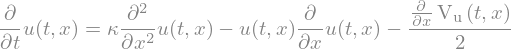

**************************************************


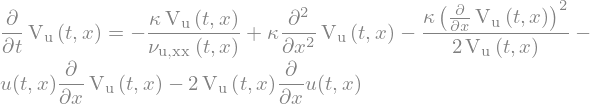

**************************************************


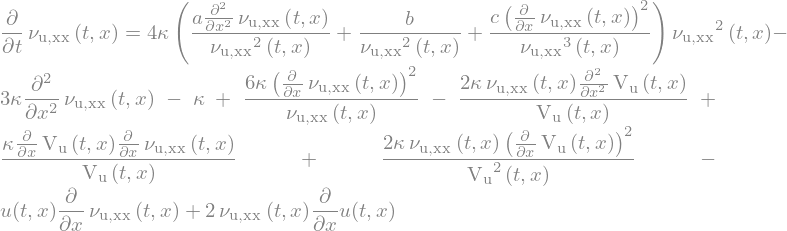

**************************************************


In [22]:
display_system(pkf_dynamics)

**Set initial PKF fields**

In [23]:
# Set initial condition for the variance parameter 'V_u'
V0 = (0.01*Umax)**2 + 0*U0

# Set the initial condition for the diffusion 
# L**2 = 2nu t => nu = 0.5*L**2
lh = 0.02*domain.lengths[0]
nu0 = 0.5*lh**2 + 0*U0

state0 = np.asarray([U0, V0,nu0])
normalization = {
                'Velocity':U0.max(), 
                'Variance':V0.max(), 
                'Length-scale':lh
                }

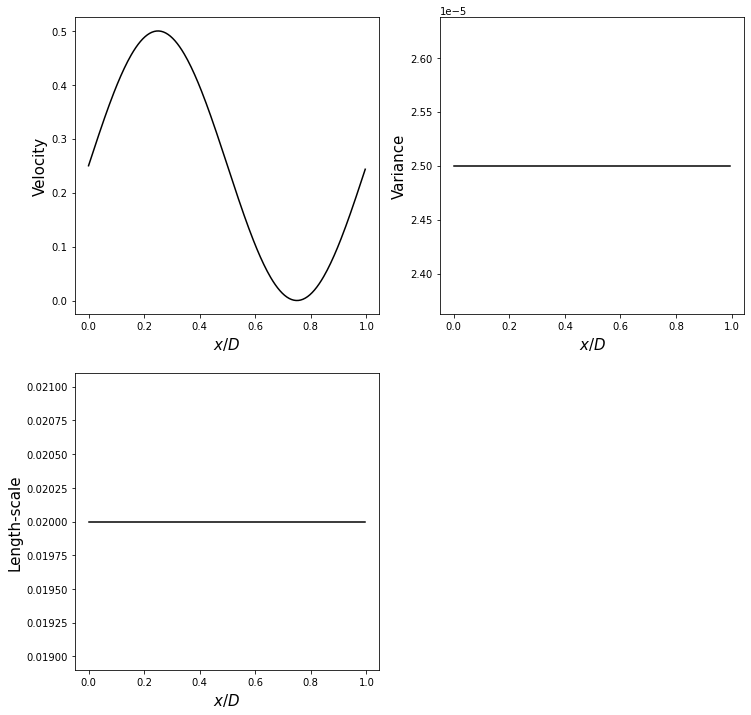

In [24]:
length_scale = lambda nu: np.sqrt(2*nu)
plt.figure(figsize=(12,12))
for k,field in enumerate(normalization):
    plt.subplot(221+k)
    if field=='Length-scale':
        data = {0:length_scale(state0[k])}
    else:
        data = {0:state0[k]}
    plot_results(data, label=field)


## Numerical application

In [25]:
def plot_pkf_traj_ensemble(traj):
    plt.figure(figsize=(15,5))
    for k,field in enumerate(normalization):
        if field=='Length-scale':
            data = {time:length_scale(traj[time][k]) for time in traj}
        else:
            data = {time:traj[time][k] for time in traj}
        plt.subplot(131+k)
        plot_results(data,label=field,normalisation=normalization[field])

In [26]:
state0 = np.asarray([U0.reshape((1,)+U0.shape+(1,)), 
                     V0.reshape((1,)+V0.shape+(1,)), 
                     nu0.reshape((1,)+nu0.shape+(1,))])

In [27]:
def plot_pkf_traj_NN(traj):
    plt.figure(figsize=(15,5))
    for k,field in enumerate(normalization):
        if field=='Length-scale':
            data = {time:length_scale(traj[time][k][0,:,0]) for time in traj}
        else:
                data = {time:traj[time][k][0,:,0] for time in traj}
        plt.subplot(131+k)
        plot_results(data,label=field,normalisation=normalization[field])
    
#plt.savefig("./figures/NN-PKF-closure_loc-gaussian.jpg")    

## Generation of a database <a id='set-database'/>

##### **Gaussian random vector of Gaussian correlation function**

In [28]:
# Création d'une matrice de covariance d'erreur de prévision initiale: $P_0$
#   Cette matrice est construite comme une matrice homogène de corrélation Gaussienne et de longueur de portée l_h

# 1) Définition de la fonction de corrélation homogène
gauss = lambda x : np.exp(-0.5*x**2/lh**2) # lh has been previously specified 
correlation = gauss(domain.x[0]-domain.x[0][domain.shape[0]//2])
spectrum = np.abs(np.fft.fft(correlation))

# 2) Construction de B^(1/2)
std_spectrum = np.sqrt(spectrum)
def make_sample():
    zeta = np.random.normal(size=domain.shape)
    zeta = np.fft.fft(zeta)
    ef = np.fft.ifft(std_spectrum * zeta)
    ef = np.real(ef)
    return ef

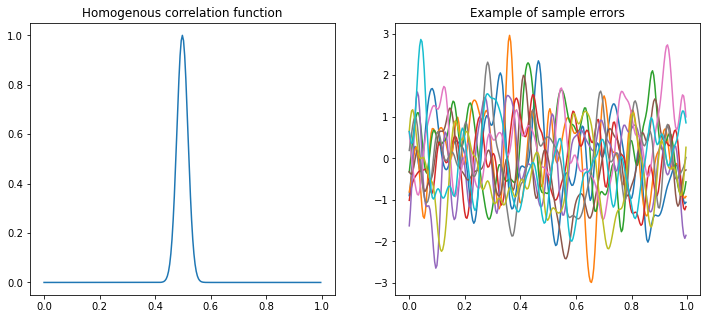

In [29]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(domain.x[0], correlation)
plt.title('Homogenous correlation function');
plt.subplot(122)
for k in range(10):
    plt.plot(domain.x[0], make_sample())
plt.title("Example of sample errors");

##### **Diagnosis tool for ensemble estimation of expectation/variance/diffusion tensor**

In [30]:
def make_init_ensemble(Ne):
    return np.array([make_sample() for k in range(Ne)])

def estimate_covariance(ensemble):
    mean = ensemble.mean(0)
    error = (ensemble - mean)/np.sqrt(len(ensemble))
    return error.T @ error

class EnsembleDiagnosis(object):
    
    def __init__(self, ensemble, base_space):
        self.base_space = base_space
        
        if isinstance(ensemble, list):
            ensemble = np.array(ensemble)
        
        if len(ensemble.shape)==3:
            ensemble = np.array([elm[0] for elm in ensemble])
        
        # 1) Computation of the mean
        self.mean = ensemble.mean(axis=0)
        
        # 2) Computation of the variance
        self.std = ensemble.std(axis=0)
        self.variance = self.std*self.std
        
        # 3) Computation of the metric terms 
        #  we use the formula g_ij = E[(D_i eps)(D_j eps)]
        
        #  a) Computation of the normalized error
        epsilon = (ensemble-self.mean)/self.std
        
        #  b) Computation of derivatives
        n = self.base_space.shape[0]
        K = np.arange(n)
        kp = (K+1)%n
        km = (K-1)%n
        dx = self.base_space.dx[0]
        Depsilon = np.array([(eps[kp]-eps[km])/(2*dx) for eps in epsilon])
        self.metric = (Depsilon*Depsilon).mean(axis=0)     # see Pannekoucke et al. (2018) for details   
        
        # Computation of the diffusion tensor
        self.diffusion = 0.5*1/self.metric
        self.length_scale = np.sqrt(2*self.diffusion)

##### **Ensemble validation for the covariance setting**

Validation of the mean (=0): -0.0003522713850680207 +/- 0.029235862275939016
Validation of the standard-deviation (=1): 0.9953380974484286 +/- 0.01687155341458293


Text(0.5, 1.0, 'diffusion (normalisée par $nu_h$)')

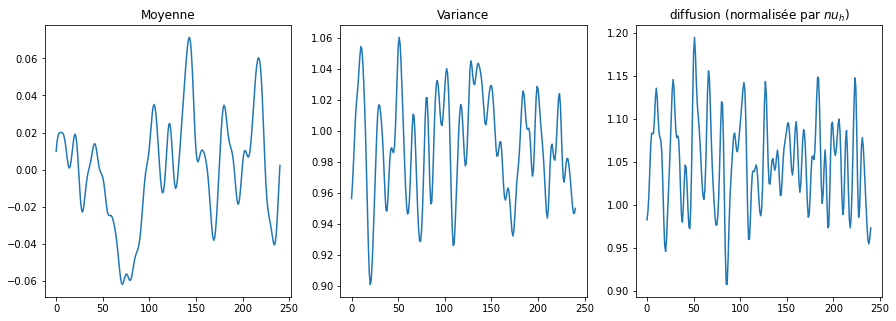

In [31]:
Ne = 1600

ensemble = make_init_ensemble(Ne)

mean = ensemble.mean(axis=0)
std = ensemble.std(axis=0)

print(f"Validation of the mean (=0): {mean.mean()} +/- {mean.std()}" )
print(f"Validation of the standard-deviation (=1): {std.mean()} +/- {std.std()}" )

ens_diagnosis = EnsembleDiagnosis(ensemble, domain)
nu_h = 0.5*lh**2

plt.figure(figsize=(15,5))

plt.subplot(131)
plt.plot(ens_diagnosis.mean)
plt.title('Moyenne')

plt.subplot(132)
plt.plot(ens_diagnosis.variance)
plt.title('Variance')

plt.subplot(133)
plt.plot(ens_diagnosis.diffusion/nu_h)
plt.title('diffusion (normalisée par $nu_h$)')

**Computation of a large ensemble (1600 members) to build a reference**

In [32]:
# Standard deviation for the initial perturbation
sigma_f = 0.01*U0.max()

In [33]:
# Set parameters for ensemble estimation
large_Ne = 1600

# 1. Set the initial background state
random_U0 = U0 + sigma_f*make_init_ensemble(1)[0]

# 2. Build an ensemble of initial perturbed state
ensemble = make_init_ensemble(large_Ne)
ensemble_ea = np.array([random_U0+sigma_f*ea for ea in ensemble])
ensemble_ea = ensemble_ea.reshape((1,)+ensemble_ea.shape+(1,))
print(f"shape of ensemble_ea: {ensemble_ea.shape}")

# 3. Build the ensemble of forecast using the NN architecture
ensemble_forecast = burgers.forecast(times,ensemble_ea)

# 4. Compute diagnosis from ensemble
ensemble_traj = {}
for time in times[::50]:
    diagnosis = EnsembleDiagnosis(ensemble_forecast[time][0,:,:,0], domain)
    ensemble_traj[time] = [diagnosis.mean, diagnosis.variance, diagnosis.diffusion]

shape of ensemble_ea: (1, 1600, 241, 1)


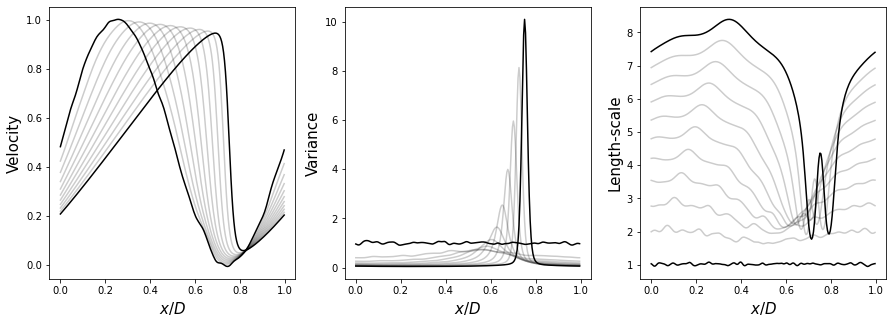

In [34]:
plot_pkf_traj_ensemble(ensemble_traj)

#### **Generation of the training data set**

In [35]:
def generate_data(k, Ne=400):
    # 1. Set the initial background state
    random_U0 = U0 + sigma_f*make_init_ensemble(1)[0]

    # 2. Build an ensemble of initial perturbed state
    ensemble = make_init_ensemble(Ne)
    ensemble_ea = np.array([random_U0+sigma_f*ea for ea in ensemble])
    ensemble_ea = ensemble_ea.reshape((1,)+ensemble_ea.shape+(1,))    
        
    # 3. Compute the ensemble of forecasts
    ensemble_forecast = burgers.forecast(times,ensemble_ea)

    # 4. Compute the diagnosis    
    diagnosis_list = []
    for time in times:
        diagnosis = EnsembleDiagnosis(ensemble_forecast[time][0,:,:,0], domain)
        diagnosis_list.append( np.array([diagnosis.mean, diagnosis.variance, diagnosis.diffusion]))
        
    return diagnosis_list

In [36]:
data_size = 400  # for Ne=400, this takes 1h09'01'' so take care with this..
save_file = "pkf-dataset.npy"

generate_data_set = False
parallel_diagnosis = False
    
try:
    # load data
    data = np.load(save_file)
    data = data.reshape(data.shape+(1,))
except:
    # 1. Generate data   
    #data = [generate_data(k) for k in range(data_size)]
    data = []
    for k in range(data_size):
        if k%5==0:
            print(k)
        data.append(generate_data(k))
    

    # 2. Save data
    data = np.array(data)
    np.save(save_file,data)
    

In [37]:
data.shape

### Training of the closure

**Make a RK4 time scheme**

In [38]:
def make_time_scheme(dt, trend):
    """ Implementation of an RK4 with Keras """
    
    state = keras.layers.Input(shape = trend.input_shape[1:])
    
    # k1 
    k1 = trend(state)
    # k2 
    _tmp_1 = keras.layers.Lambda(lambda x : 0.5*dt*x)(k1)
    input_k2 = keras.layers.add([state,_tmp_1])
    k2 = trend(input_k2)
    # k3 
    _tmp_2 = keras.layers.Lambda(lambda x : 0.5*dt*x)(k2)
    input_k3 = keras.layers.add([state,_tmp_2])
    k3 = trend(input_k3)
    # k4 
    _tmp_3 = keras.layers.Lambda(lambda x : dt*x)(k3)
    input_k4 = keras.layers.add([state,_tmp_3])
    k4 = trend(input_k4)
    
    # output
    # k2+k3
    add_k2_k3 = keras.layers.add([k2,k3])
    add_k2_k3_mul2 = keras.layers.Lambda(lambda x:2.*x)(add_k2_k3)
    # Add k1,k4
    _sum = keras.layers.add([k1,add_k2_k3_mul2,k4])
    # *dt
    _sc_mul = keras.layers.Lambda(lambda x:dt/6.*x)(_sum)
    output = keras.layers.add([state, _sc_mul])
    
    time_scheme = keras.models.Model(inputs =[state], 
                                     outputs=[output])
    return time_scheme 

In [39]:
closed_pkf_burgers = ClosedPKFBurgers(shape=(241,),kappa=kappa)

In [40]:
closed_pkf_burgers._make_dynamical_trend()

In [41]:
time_scheme = make_time_scheme(dt, closed_pkf_burgers._dynamical_trend)
#time_scheme.summary()

In [42]:
closed_pkf_burgers._dynamical_trend.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 3, 241, 1)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 241, 1)       0           input_5[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 241, 1)       0           input_5[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 241, 1)       0           input_5[0][0]                    
____________________________________________________________________________________________

#### Constitution de la base de données d'apprentissage

In [43]:
data[0].shape

In [44]:
select_from = 400 # 200
X = np.array([elm[select_from:-1] for elm in data])
Y = np.array([elm[select_from+1:] for elm in data])

In [45]:
X = X.reshape((np.prod(X.shape[:2]),3,241,1))
Y = Y.reshape((np.prod(Y.shape[:2]),3,241,1))

In [46]:
X.shape

#### **Training of the NN**

In [47]:
closed_pkf_burgers._trend_model.get_layer('TrainableScalar_a').get_weights()[0].shape

In [48]:
# Value of the unknowns (a,b,c) before the training
untrained = []
for l in "abc":
    untrained.append(float(closed_pkf_burgers._trend_model.get_layer('TrainableScalar_'+l).get_weights()[0]))
    print(f"{l}: {untrained[-1]}")

a: -0.4491160809993744
b: 0.7526848912239075
c: 0.9891307950019836


In [49]:
closed_pkf_burgers._dynamical_trend.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 3, 241, 1)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 241, 1)       0           input_5[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 241, 1)       0           input_5[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 241, 1)       0           input_5[0][0]                    
____________________________________________________________________________________________

iteration 0 is complet
iteration 1 is complet
iteration 2 is complet


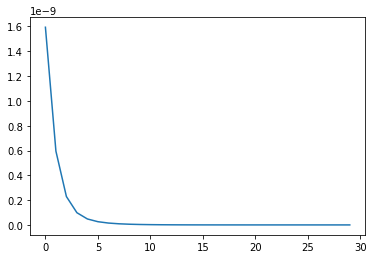

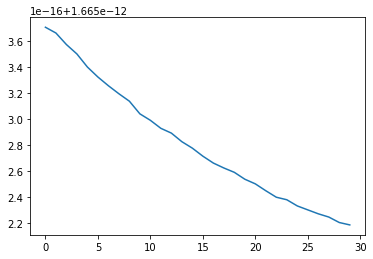

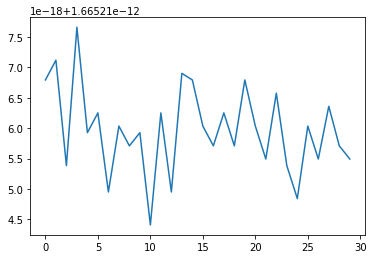

In [50]:
# Expérience d'apprentissage:
# 2. Adam
lr = 0.1 
epochs = 30

for iteration in range(3):
    # 1. Set the learning
    time_scheme.compile(optimizer=keras.optimizers.Adam(lr=lr),
        loss='mean_squared_error') 
    
    # 2. Train
    history = time_scheme.fit(X,Y,epochs=epochs, batch_size=32,verbose=0)
    print(f"iteration {iteration} is complet")
    
    # 3. Plot history    
    plt.figure()
    plt.plot(history.history['loss'])
    
    # 4. Update the learning rate for next iteration
    lr = lr/10
    



### Comparison with the theoretically designed closure

**Compare the weights with the previous theoretical closure**

In [51]:
#closed_pkf_burgers._trend_model.summary()

In [52]:
trained = []
for l in "abc":
    trained.append(float(closed_pkf_burgers._trend_model.get_layer('TrainableScalar_'+l).get_weights()[0]))
    print(f"{l}: {trained[-1]}")

a: 0.9331281185150146
b: 0.7518517971038818
c: -1.8038628101348877


The weights of the theoretical closure are : 1, 3/4, -2

In [53]:
trained = np.array((trained[0], trained[1], trained[2])).flatten()
trained

array([ 0.93312812,  0.7518518 , -1.80386281])

In [54]:
theoretical = np.array([1,3/4,-2])

In [55]:
relative_error = (trained - theoretical)/theoretical

In [56]:
relative_error*100

array([-6.68718815,  0.24690628, -9.80685949])

**Exemple de prévision réalisée avec le modèle calibré**

In [57]:
# default
closed_pkf_burgers.set_dt(dt)
times = closed_pkf_burgers.window(1)
saved_times = times[::50]
print('saved_times :' ,saved_times)

saved_times : [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [58]:
state0.shape

In [59]:
trained_unclosed_traj = closed_pkf_burgers.forecast(times, state0, saved_times)

In [60]:
normalization

{'Velocity': 0.4999946897600651,
 'Variance': 2.4999468978826374e-05,
 'Length-scale': 0.02}

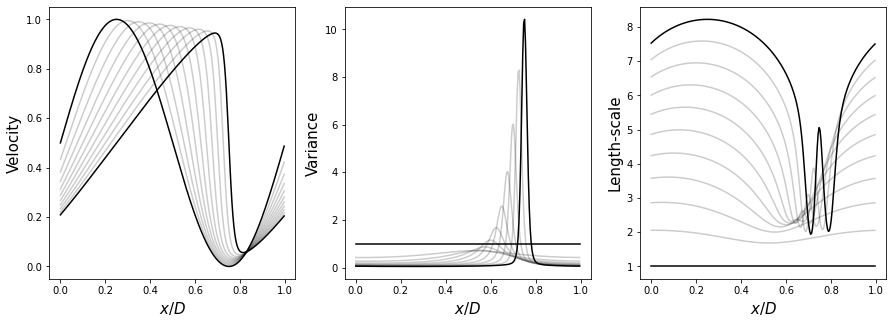

In [61]:
# PKF using trained closure
plot_pkf_traj_NN(trained_unclosed_traj)
plt.savefig('./figures/burgers-TrainableScalar-b.pdf')

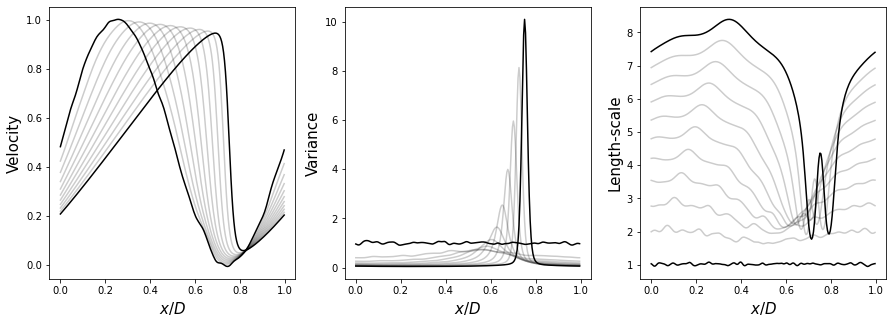

In [62]:
# ensemble of forecast statistics
plot_pkf_traj_ensemble(ensemble_traj)
plt.savefig('./figures/burgers-TrainableScalar-a.pdf')

## Conclusion <a id='conclusion'/>

In this notebook, we have considered the uncertainty prediction for the Burgers dynamics where an unclosed term is present.

A closure has been proposed and implemented as **a symbolic expression where unknown quantities are defined as `TrainableScalar`**
which are translated into a trainable neural network.

A synthetic dataset has been used to train the NN. The resulting closure has shown to be relevant to predict the uncertainty.